# **Classification for IsFree and FreeVerAvail**

This notebook looks into the machine learning algorithms of classification, primarily on the features IsFree and FreeVerAvail from the Steam Games Dataset. This will classify between whether a game is popular based on a couple of features, specifically IsFree and FreeVerAvail, along with other features as well. 

We'll be using four different types of classification methods which include logistic regression, decision tree, support vector machine, and K Nearest Neighbors. 

**Note**: Running this notebook might take a while

In [3]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm


# silence warnings
import warnings
warnings.filterwarnings('ignore')

# **Clean Dataset**

We'll be dropping the games with 0 SteamSpyOwners, which means that either that game has no owners at all or it hasn't been released yet. We'll be keeping the columns SteamSpyOwners, IsFree, FreeVerAvail, and Genre categories. We'll also take the log of SteamSpyOwners, as that has proven to be more reliable in plotting as seen in previous notebooks and data analysis. 

In [4]:
# Link might need to be updated based on GitHub
df = pd.read_csv('https://raw.githubusercontent.com/COGS108/group036_fa20/master/Datasets/games-features.csv?token=AFASGDG236VMGHN44GU6Z4K72JSFU')

df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors='coerce')
df = df.loc[df['ReleaseDate'].notnull()]
df = df.loc[df['GenreIsNonGame'] == False]
# CONSIDER DROPPING GAMES THAT HAVEN'T BEEN OWNED
df = df.loc[df['SteamSpyOwners'] > 0]
df = df.drop(columns=['QueryID', 'ResponseID', 'QueryName', 'PackageCount',
                      'AchievementHighlightedCount', 'AchievementCount', 'ControllerSupport', 'PCReqsHaveMin',
                      'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
                      'MacReqsHaveRec', 'SupportEmail', 'SupportURL', 'ExtUserAcctNotice',
                      'HeaderImage', 'LegalNotice', 'Website', 'PCMinReqsText',
                      'PCRecReqsText', 'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText',
                      'MacRecReqsText'])
# log of SteamSpyOwners
df['log_owners'] = np.log(df['SteamSpyOwners'])

# Take the year of the release date of a game
df['ReleaseYear'] = df['ReleaseDate'].dt.year

df.head()

,ResponseName,ReleaseDate,RequiredAge,DemoCount,DeveloperCount,DLCCount,Metacritic,MovieCount,RecommendationCount,PublisherCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,IsFree,FreeVerAvail,PurchaseAvail,SubscriptionAvail,PlatformWindows,PlatformLinux,PlatformMac,CategorySinglePlayer,CategoryMultiplayer,CategoryCoop,CategoryMMO,CategoryInAppPurchase,CategoryIncludeSrcSDK,CategoryIncludeLevelEditor,CategoryVRSupport,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,PriceCurrency,PriceInitial,PriceFinal,AboutText,Background,ShortDescrip,DetailedDescrip,DRMNotice,Reviews,SupportedLanguages,log_owners,ReleaseYear
0,Counter-Strike,2000-11-01,0,0,1,0,88,0,68991,1,13,13033334,92789,9140731,78136,False,False,True,False,True,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,USD,9.99,9.99,Play the worlds number 1 online action game. E...,http://cdn.akamai.steamstatic.com/steam/apps/1...,,Play the worlds number 1 online action game. E...,,,English French German Italian Spanish Simplifi...,16.383021,2000
1,Team Fortress Classic,1999-04-01,0,0,1,0,0,0,2439,1,5,5399140,60368,753627,22699,False,False,True,False,True,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,USD,4.99,4.99,One of the most popular online action games of...,http://cdn.akamai.steamstatic.com/steam/apps/2...,,One of the most popular online action games of...,,,English French German Italian Spanish,15.501750,1999
2,Day of Defeat,2003-05-01,0,0,1,0,79,0,2319,1,5,7621102,71499,1709740,34145,False,False,True,False,True,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,USD,4.99,4.99,Enlist in an intense brand of Axis vs. Allied ...,http://cdn.akamai.steamstatic.com/steam/apps/3...,,Enlist in an intense brand of Axis vs. Allied ...,,,English French German Italian Spanish,15.846432,2003
3,Deathmatch Classic,2001-06-01,0,0,1,0,0,0,888,1,4,7498965,70936,789676,23235,False,False,True,False,True,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,USD,4.99,4.99,Enjoy fast-paced multiplayer gaming with Death...,http://cdn.akamai.steamstatic.com/steam/apps/4...,,Enjoy fast-paced multiplayer gaming with Death...,,,English French German Italian Spanish,15.830276,2001
4,Half-Life: Opposing Force,1999-11-01,0,0,1,0,0,0,2934,1,5,5399499,60370,705741,21968,False,False,True,False,True,True,True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,USD,4.99,4.99,Return to the Black Mesa Research Facility as ...,http://cdn.akamai.steamstatic.com/steam/apps/5...,,Return to the Black Mesa Research Facility as ...,,,English French German Korean,15.501817,1999


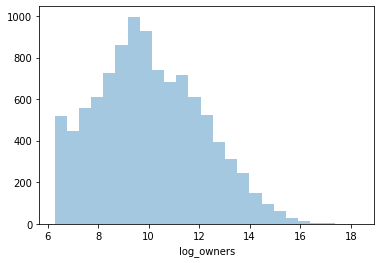

In [5]:
# Plot out distribution of log owners, which we'll use for categories to classify
sns.distplot(df['log_owners'], bins = 25, kde = False)
plt.show()

After looking at how log owners is distributed, we'll consider greater than 10 to be popular, which is equivalent to around 22,000 owners. 

In [6]:
threshold = 10
df['Popular'] = df['log_owners'].apply(lambda x: True if x >= threshold else False)

In [7]:
categories = ['IsFree', 'FreeVerAvail', 'Popular']
subset = df[categories]
subset.head()

,IsFree,FreeVerAvail,Popular
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


# **Split data into test and training data**

We'll be spliting the test and training data by an 30% 70% split. 

In [8]:
x_train, x_test, y_train, y_test = train_test_split(subset.drop(columns = ['Popular']), 
                                                    np.array(subset['Popular']).reshape(-1,1), test_size = 0.3)

# **Test Classification on IsFree and FreeVerAvail alone**

We'll now be conducting the four classification models on the two featrues IsFree and FreeVerAvail. 

In [9]:
svm = SVC(kernel = 'linear', C = 0.025, random_state = 101)
lr = LogisticRegression()
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15)

In [10]:
agg_models = [lr, dtree, svm]
model_names = ['lr', 'dtree', 'svm']

In [11]:
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors = i)
    model_names.append('knn' + str(i))
    agg_models.append(knn)

In [12]:
score_lst = []
for i in range(len(agg_models)):
    model = agg_models[i]
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    score_lst.append([model.score(x_train, y_train), model.score(x_test, y_test)])

In [13]:
joined_scores = pd.DataFrame(dict(zip(model_names, score_lst))).T
joined_scores.columns = ['train_score', 'test_score']
joined_scores.head()

,train_score,test_score
lr,0.594016,0.575016
dtree,0.593877,0.574690
svm,0.593877,0.574690
knn1,0.594016,0.575016
knn2,0.593877,0.574690


# **Results of Classification Accuracy**

After performing the four different methods of classification on IsFree and FreeVerAvail, it seems like most of the scores are pretty similar at around 58% accuracy, which is better than choosing at random. However, there doesn't seem to be any difference between the classification methods, so we'll be adding more features to look into. 

In [14]:
display(joined_scores.loc[joined_scores['train_score'].idxmax()])
display(joined_scores.loc[joined_scores['test_score'].idxmax()])

train_score    0.594016
test_score     0.575016
Name: lr, dtype: float64

train_score    0.594016
test_score     0.575016
Name: lr, dtype: float64

Although all the classification models seem to have a similar score, logistic regression has the highest accuracy in both training and test scores. 

# **Cross Validation Scores Using Entire Dataset**

Now we'll be doing cross validation for the two features on the entire dataset. 

In [15]:
svm = SVC(kernel = 'linear', C = 0.025, random_state = 101)
lr = LogisticRegression()
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15)

In [16]:
agg_models = [lr, dtree, svm]
model_names = ['lr', 'dtree', 'svm']

In [17]:
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors = i)
    model_names.append('knn' + str(i))
    agg_models.append(knn)

In [18]:
scores = {}
for i in range(len(agg_models)):
    score = cross_val_score(agg_models[i], subset.drop(columns = ['Popular']), subset['Popular'], cv =5)
    scores[model_names[i]] = score

In [19]:
scores_df = pd.DataFrame(scores).T
scores_df['mean'] = scores_df.apply(lambda x: x.mean(), axis = 1)
scores_df.columns = ['1st_set', '2nd_set', '3rd_set', '4th_set', '5th_set', 'mean']
scores_df.head()

,1st_set,2nd_set,3rd_set,4th_set,5th_set,mean
lr,0.546967,0.573386,0.559687,0.611546,0.650024,0.588322
dtree,0.546967,0.573386,0.559198,0.611057,0.650024,0.588126
svm,0.546967,0.573386,0.559198,0.611057,0.650024,0.588126
knn1,0.472603,0.472603,0.472114,0.472114,0.472345,0.472355
knn2,0.472603,0.472603,0.472114,0.471624,0.472345,0.472258


# **Results of Cross Validation Scores**

After performing a cross validation across all four methods of classification, it seems like KNN's accuracy is worse than choosing at random. However, the other three methods, including Logistic Regression, Decision Tree, and SVM all have a pretty similar mean score. Overall, logistic regression seems to have the highest mean score of 0.58 which is better than choosing at random

In [20]:
display(scores_df.loc[scores_df['mean'].idxmax()])

1st_set    0.546967
2nd_set    0.573386
3rd_set    0.559687
4th_set    0.611546
5th_set    0.650024
mean       0.588322
Name: lr, dtype: float64

# **Classification with Genre**

Now that we did some classification with just IsFree and FreeVerAvail, we'll now add that to the categories of game genres. We want to see if we can get a more accurate classification if we add more features. 

In [21]:
lst = ['IsFree', 'FreeVerAvail', 'GenreIsNonGame',
        'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual',
        'GenreIsStrategy', 'GenreIsRPG', 'GenreIsSimulation', 'GenreIsEarlyAccess',
        'GenreIsFreeToPlay', 'GenreIsSports', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer', 'Popular']
subset = df[lst]

In [22]:
# Split test and training data
x_train, x_test, y_train, y_test = train_test_split(subset.drop(columns = ['Popular']), 
                                                    np.array(subset['Popular']).reshape(-1,1), test_size = 0.3)

In [23]:
svm = SVC(kernel = 'linear', C = 0.025, random_state = 101)
lr = LogisticRegression()
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15)

In [24]:
agg_models = [lr, dtree, svm]
model_names = ['lr', 'dtree', 'svm']

In [25]:
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors = i)
    model_names.append('knn' + str(i))
    agg_models.append(knn)

In [26]:
score_lst = []
for i in range(len(agg_models)):
    model = agg_models[i]
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    score_lst.append([model.score(x_train, y_train), model.score(x_test, y_test)])

In [27]:
joined_scores = pd.DataFrame(dict(zip(model_names, score_lst))).T
joined_scores.columns = ['train_score', 'test_score']
joined_scores.head()

,train_score,test_score
lr,0.659723,0.643509
dtree,0.670208,0.651011
svm,0.637914,0.618069
knn1,0.580036,0.539791
knn2,0.607158,0.584149


# **Results of Classification with Genres**

After performing all four different classification methods, it seems that the best scoring classification is KNN with 34 neighbors. Both the training and test scores of KNN with 34 neighbors is around 0.66, which is a lot better than just IsFree and FreeVerAvail. 

Many of the other methods of classification also do similarly well in the mid 60's, which are all better than classifiying only be IsFree and FreeVerAvail. So it looks like adding genre does help with classification. 

In [28]:
display(joined_scores.loc[joined_scores['train_score'].idxmax()])
display(joined_scores.loc[joined_scores['test_score'].idxmax()])

train_score    0.672305
test_score     0.644814
Name: knn16, dtype: float64

train_score    0.670069
test_score     0.652968
Name: knn24, dtype: float64

# **Cross Validation with Genre**

Now we'll do a cross validation across the entire data set using the various classification methods on IsFree, FreeVerAvail, and the genre categories. 

In [29]:
svm = SVC(kernel = 'linear', C = 0.025, random_state = 101)
lr = LogisticRegression()
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15)

In [30]:
agg_models = [lr, dtree, svm]
model_names = ['lr', 'dtree', 'svm']

In [31]:
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors = i)
    model_names.append('knn' + str(i))
    agg_models.append(knn)

In [32]:
scores = {}
for i in range(len(agg_models)):
    score = cross_val_score(agg_models[i], subset.drop(columns = ['Popular']), subset['Popular'], cv =5)
    scores[model_names[i]] = score

In [33]:
scores_df = pd.DataFrame(scores).T
scores_df['mean'] = scores_df.apply(lambda x: x.mean(), axis = 1)
scores_df.columns = ['1st_set', '2nd_set', '3rd_set', '4th_set', '5th_set', 'mean']
scores_df.head()

,1st_set,2nd_set,3rd_set,4th_set,5th_set,mean
lr,0.703523,0.649217,0.610078,0.657045,0.661282,0.656229
dtree,0.689335,0.640411,0.591487,0.659980,0.669114,0.650065
svm,0.574853,0.629648,0.588552,0.635519,0.620656,0.609845
knn1,0.482387,0.477006,0.515656,0.502446,0.510034,0.497506
knn2,0.495108,0.491683,0.545499,0.520059,0.523740,0.515218


# **Results of Cross Validation**

After performing a cross validation using the entire dataset and with multiple different methods of classification, the best scoring method is logistic regression. The mean of the scoring is 0.65, which is approximately the same as many of the results when we used a set training and testing data. However, many of the methods we used are better in classifying whether a game is popular or not than a random coin flip. 

In [34]:
display(scores_df.loc[scores_df['mean'].idxmax()])

1st_set    0.703523
2nd_set    0.649217
3rd_set    0.610078
4th_set    0.657045
5th_set    0.661282
mean       0.656229
Name: lr, dtype: float64

# **Conclusion**

After performing all the classification methods on IsFree and FreeVerAvail on their own and then with genre categories, we can say that adding genre helped increase the accuracy of the classification, and that classification under these features are better than guessing at random. Although the accuracies of our classification didn't yield any surprisingly high scores, the classification models we built have some potential in whether a game will have over 22,000 owners on Steam or not. 

However, one thing we should take into consideration is how well genre performed on its own. In another notebook, we saw that many of the best scoring classification models had a score of around 0.65, which isn't any different as when we added genre to IsFree and FreeVerAvail. So that could mean that IsFree and FreeVerAvail isn't that helpful when doing classification, and that genre could be a very important feature in determining whether a game is popular. 


Link to Notebook on classification using only genre: 

https://github.com/COGS108/group036_fa20/blob/master/Classification/Classification_In_Meeting.ipynb